# **FINE TUNING FASTER RCNN USING PYTORCH**

Hello Everyone!

In this Notebook I will show you how we can fine tune a Faster RCNN on the fruits images dataset. If you want to brush up about what is Faster RCNN, [here's](https://medium.com/@whatdhack/a-deeper-look-at-how-faster-rcnn-works-84081284e1cd) an awesome medium article on the same.

The code is inspired by the Pytorch docs tutorial [here](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)


## Installs and Imports

Since a lot of code for object detection is same and has to be rewritten by everyone, torchvision contributers have provided us with helper codes for training, evaluation and transformations.

Let's clone the repo and copy the libraries into working directory

In [2]:
# Download TorchVision repo to use some files from
# references/detection
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

Cloning into 'vision'...
remote: Enumerating objects: 469869, done.
remote: Counting objects: 100% (50327/50327), done.
remote: Compressing objects: 100% (2345/2345), done.
remote: Total 469869 (delta 48053), reused 50124 (delta 47906), pack-reused 419542
Receiving objects: 100% (469869/469869), 923.23 MiB | 46.38 MiB/s, done.
Resolving deltas: 100% (437156/437156), done.
error: pathspec 'v0.3.0' did not match any file(s) known to git


Lets import the libraries

In [1]:
# Basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

# xml library for parsing xml files
from xml.etree import ElementTree as et

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# these are the helper libraries imported.
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import pickle

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval


In [2]:
classes = [_, 'A10','A400M','AG600', 'B1','B2',
                        'B52','Be200','C130','C17','C5','E2','EF2000','F117','F14',
                        'F15','F16','F18','F22','F35','F4','J20','JAS39',
                        'MQ9','Mig31','Mirage2000','RQ4','Rafale','SR71',
                        'Su57','Tu160','Tu95','U2','US2','V22','Vulcan','XB70','YF23']

In [3]:
len(classes)

38

## Dataset

Lets build the Aircrafts images dataset!

In [5]:
### New Attempt w/ pickle

# defining the files directory and testing directory
files_dir = '/home/jupyter/images_gcs/det_modify/train'
test_dir = '/home/jupyter/images_gcs/det_modify/test'
val_dir = '/home/jupyter/images_gcs/det_modify/val'


train_pickle = '/home/jupyter/images_gcs/det_modify/label_train_df.pkl'
test_pickle = '/home/jupyter/images_gcs/det_modify/label_test_df.pkl'
val_pickle = '/home/jupyter/images_gcs/det_modify/label_val_df.pkl'

class AircraftsDataset(torch.utils.data.Dataset):

    def __init__(self, files_dir, width, height, transforms=None, pickle_file='/home/jupyter/images_gcs/det_modify/label_train_df.pkl'):
        self.transforms = transforms
        self.files_dir = files_dir
        self.height = height
        self.width = width
        self.pickle_file = pickle_file

        self.imgs = [image for image in sorted(os.listdir(files_dir)) if image[-4:]=='.jpg']

        self.classes = [_, 'A10','A400M','AG600', 'B1','B2',
                        'B52','Be200','C130','C17','C5','E2','EF2000','F117','F14',
                        'F15','F16','F18','F22','F35','F4','J20','JAS39',
                        'MQ9','Mig31','Mirage2000','RQ4','Rafale','SR71',
                        'Su57','Tu160','Tu95','U2','US2','V22','Vulcan','XB70','YF23']

        # Load the pickle file (assuming it contains a Pandas DataFrame)
        with open(self.pickle_file, 'rb') as f:
            self.df = pickle.load(f)

    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        image_path = os.path.join(self.files_dir, img_name)

        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        img_res /= 255.0

        wt = img.shape[1]
        ht = img.shape[0]

        boxes = []
        labels = []
        areas = []

        # Filter for the current image and extract bounding boxes
        img_df = self.df[self.df['filename'] == img_name[:-4]]
        #print(img_df)
        for _, row in img_df.iterrows():
            labels.append(self.classes.index(row['class']))
            xmin = row['xmin_r'] * self.width
            xmax = row['xmax_r'] * self.width
            ymin = row['ymin_r'] * self.height
            ymax = row['ymax_r'] * self.height

            #f_wt = row['width']
            #f_ht = row['height']

            #xmin_corr = (xmin / f_wt) * self.width
            #xmax_corr = (xmax / f_wt) * self.width
            #ymin_corr = (ymin / f_ht) * self.height
            #ymax_corr = (ymax / f_ht) * self.height

            boxes.append([xmin, ymin, xmax, ymax])

            # Calculate the area
            area = (xmax - xmin) * (ymax - ymin)
            areas.append(area)  # Store the area

       # convert boxes into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        areas = torch.as_tensor(areas)



        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        labels = torch.as_tensor(labels, dtype=torch.int64)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = areas
        target["iscrowd"] = iscrowd
        # image_id
        image_id = idx
        target["image_id"] = image_id


        if self.transforms:

            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)

            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])



        return img_res, target

    def __len__(self):
        return len(self.imgs)


# check dataset
dataset = AircraftsDataset(files_dir, 640, 640)
print('length of dataset = ', len(dataset), '\n')

# getting the image and target for a test index.  Feel free to change the index.
img, target = dataset[3]
print(img.shape, '\n',target)

length of dataset =  3717 

(640, 640, 3) 
 {'boxes': tensor([[138.6667, 130.5632, 534.4000, 495.0188]]), 'labels': tensor([15]), 'area': tensor([144227.2188]), 'iscrowd': tensor([0]), 'image_id': 3}


In [14]:
import pickle
import pandas as pd
import json

# **1. Load the pickle file**
with open(val_pickle, 'rb') as f:
    df = pd.read_pickle(f)

# **2. Data Preparation**
def process_row(row, image_id, class_mapping):
    category_id = class_mapping.get(row['class'], None) 
    if category_id is None:
        # Handle classes not present in the mapping
        return None  

    return {
        "id": image_id,  # Example annotation ID generation
        "image_id": image_id,
        "category_id": category_id,
        "bbox": [
            row['xmin_r']*640,
            row['ymin_r']*640,
            row['xmax_r']*640 - row['xmin_r']*640,  # Calculate width
            row['ymax_r']*640 - row['ymin_r']*640   # Calculate height
        ]
    }

# **3. Create Mapping for Classes (if you don't have one)**
class_mapping = {
'A10':1,'A400M':2,'AG600':3, 'B1':4,'B2':5,
                        'B52':6,'Be200':7,'C130':8,'C17':9,'C5':10,'E2':11,'EF2000':12,'F117':13,'F14':14,
                        'F15':15,'F16':16,'F18':17,'F22':18,'F35':19,'F4':20,'J20':21,'JAS39':22,
                        'MQ9':23,'Mig31':24,'Mirage2000':25,'RQ4':26,'Rafale':27,'SR71':28,
                        'Su57':29,'Tu160':30,'Tu95':31,'U2':32,'US2':33,'V22':34,'Vulcan':35,'XB70':36,'YF23':37
} 

# **4. Process Data**
images = []
categories = list(class_mapping.items())  # Get category ID and name pairs
annotations = []

for idx, row in df.iterrows():
    image_id = idx  # Use index as image ID for simplicity
    images.append({"id": image_id, "file_name": f"{image_id}.jpg"})

    annotation = process_row(row, image_id, class_mapping)
    if annotation:
        annotations.append(annotation)

# **5. Create JSON Structure**
data = {
    "categories": categories,
    "images": images,
    "annotations": annotations
}

# **6. Serialize to JSON**
with open('output.json', 'w') as f:
    json.dump(data, f, indent=4)

# Visualization

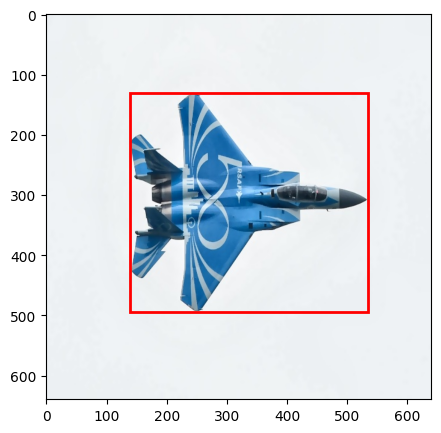

In [5]:
# Function to visualize bounding boxes in the image

def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()

# plotting the image with bboxes. Feel free to change the index
img, target = dataset[3]
plot_img_bbox(img, target)

You can see that we are doing great till now, as the bbox is correctly placed.

One thing to note is that, the dataset wants us to predict only the full apple as "apple" but not the half cut one. This will be a challenge to overcome.

Lets build the model then!

# Model

In [18]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

# Augmentations

This is where we can apply augmentations to the image.

The augmentations to object detection vary from normal augmentations becuase here we need to ensure that, bbox still aligns with the object correctly after transforming.

Here I have added random flip transform, feel free to customize it as you feel



In [17]:
# Send train=True fro training transforms and False for val/test transforms
def get_transform(train):

    if train:
        return A.Compose([
                            A.HorizontalFlip(0.5),
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

# Training

In [22]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [10]:
from engine import train_one_epoch, evaluate

# train on the GPU or on the CPU, if a GPU is not available


# split the dataset in train and test set
#torch.manual_seed(1)
#indices = torch.randperm(len(dataset)).tolist()

num_classes = 38
# use our dataset and defined transformations
dataset = AircraftsDataset(files_dir, 640, 640, transforms= get_transform(train=True), pickle_file = train_pickle)
dataset_test = AircraftsDataset(test_dir, 640, 640, transforms= get_transform(train=False), pickle_file = test_pickle)

#test_split = 0.2
#tsize = int(len(dataset)*test_split)
#dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
#dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=10,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=10,
    shuffle=False,
    num_workers=4,
    collate_fn=utils.collate_fn
)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it just for 2 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

Epoch: [0]  [  0/372]  eta: 0:43:36  lr: 0.000018  loss: 3.6185 (3.6185)  loss_classifier: 3.3650 (3.3650)  loss_box_reg: 0.2146 (0.2146)  loss_objectness: 0.0329 (0.0329)  loss_rpn_box_reg: 0.0060 (0.0060)  time: 7.0333  data: 1.9436  max mem: 8228
Epoch: [0]  [ 10/372]  eta: 0:07:10  lr: 0.000153  loss: 3.3556 (3.2971)  loss_classifier: 3.1531 (3.0083)  loss_box_reg: 0.2585 (0.2439)  loss_objectness: 0.0329 (0.0347)  loss_rpn_box_reg: 0.0079 (0.0102)  time: 1.1889  data: 0.2006  max mem: 8494
Epoch: [0]  [ 20/372]  eta: 0:05:20  lr: 0.000288  loss: 2.2007 (2.2720)  loss_classifier: 1.9045 (2.0023)  loss_box_reg: 0.2493 (0.2357)  loss_objectness: 0.0117 (0.0260)  loss_rpn_box_reg: 0.0062 (0.0081)  time: 0.6052  data: 0.0263  max mem: 8494
Epoch: [0]  [ 30/372]  eta: 0:04:38  lr: 0.000422  loss: 0.8509 (1.8166)  loss_classifier: 0.5775 (1.5512)  loss_box_reg: 0.2249 (0.2362)  loss_objectness: 0.0087 (0.0215)  loss_rpn_box_reg: 0.0062 (0.0077)  time: 0.6072  data: 0.0266  max mem: 8494


In [11]:
torch.save(model, 'model_object_detection_v2.pth')

In [8]:
model = torch.load('model_object_detection_v2.pth')

# Decode predictions

Our model predicts a lot of bounding boxes per image, to take out the overlapping ones, We will use **Non Max Suppression** if you want to brush up on that, check [this](https://towardsdatascience.com/non-maximum-suppression-nms-93ce178e177c) out.

Torchvision provides us a utility to apply nms to our predictions, lets build a function `apply_nms` using that.

In [9]:
# the function takes the original prediction and the iou threshold.

def apply_nms(orig_prediction, iou_thresh=0.3):

    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)

    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]

    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

# Testing our Model

Lets take an image from our test dataset and see, how our model does.

We will first see, how many bounding boxes does our model predict compared to actual

In [37]:
dataset_test = AircraftsDataset(val_dir, 640, 640, pickle_file=val_pickle)
print('length of dataset = ', len(dataset_test), '\n')

length of dataset =  797 



In [39]:
img, target = dataset_test[1]

In [41]:
def eval_transform(image):
    transform = A.Compose([
    ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

    return transform(image=image)  # Pass 'image' as a keyword argument

In [42]:
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes
from torchvision.io import read_image



#image = read_image("/home/jupyter/images_gcs/det_modify/val/00afb4420bdce881ad216867c713c800.jpg")
image, target  = dataset_test[1]
#eval_transform = eval_transform(image=image)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    predictions = model([image, ])
    pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"class: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")


plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))

ValueError: Your 'label_fields' are not valid - them must have same names as params in dict

In [15]:
# pick one image from the test set
img, target = dataset_test[5]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img])[0]

print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

AttributeError: 'numpy.ndarray' object has no attribute 'dim'

Whoa! Thats a lot of bboxes. Lets plot them and check what did it predict

In [ ]:
print('EXPECTED OUTPUT')
plot_img_bbox(torch_to_pil(img), target)

In [ ]:
print('MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), prediction)

In [ ]:
nms_prediction = apply_nms(prediction, iou_thresh=0.2)
print('NMS APPLIED MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), nms_prediction)

Now lets take an image from the test set and try to predict on it

In [ ]:
test_dataset = FruitImagesDataset(test_dir, 480, 480, transforms= get_transform(train=True))
# pick one image from the test set
img, target = test_dataset[10]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]

print('EXPECTED OUTPUT\n')
plot_img_bbox(torch_to_pil(img), target)
print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, iou_thresh=0.01)

plot_img_bbox(torch_to_pil(img), nms_prediction)

The model does well on single object images.

You can see that our model predicts the slices too and that means a failure ☹️ . But fear not, this is just a base line model here are some ideas we can improve it -
1. Use a better model.
   We have the option of changing the backbone of our model which at present is `resnet 50` and the fine tune it.
   
2. We can change the training configurations like size of the images, optimizers and learning rate schedule.
3. We can add more augmentations.
   We have used the Albumentations library which has an extensive library of data augmentation functions. Feel free to explore and try them out.

# Fin.

That's it for the notebook.

Please tell me if you have any suggestions to improve this kernel or if you find any errors. I will be glad to hear them.

If you find the notebook useful, Consider upvoting this kernel :)